In [3]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import numpy as np
import scipy.io
import torch
from pathlib import Path
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-b627a593.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-cd907fc2.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-394f9c45.pth',
}

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None): 
        super(BasicBlock, self).__init__()
        # Conv1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        # Conv2
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        # downsample
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
		# F(x)+x
        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4 

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # conv1   1x1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # conv2   3x3
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # conv3   1x1  
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):  
    # layers=参数列表 block选择不同的类
        self.inplanes = 64 
        super(ResNet, self).__init__()
        # 1.conv1
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # 2.conv2_x
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        # 3.conv3_x
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # 4.conv4_x
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # 5.conv5_x
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
		
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))   

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1) 
        x = self.fc(x)

        return x

def resnet18(pretrained=False):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

def resnet34(pretrained=False):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3])
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model

# resnet50
def resnet50(pretrained=False):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3])
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

# resnet101
def resnet101(pretrained=False):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3])
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model

def resnet152(pretrained=False):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3])
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [4]:
def data_augmentation(labels,imgs_path,img_dir):
    new_labels = labels
    new_imgs_path = imgs_path
    classes = list(count_dict_sorted.keys())[40:]
    start_id = 8190
    for i in range(len(labels)):
        if cat_to_name[labels[i]-1] in classes:
            img = Image.open(imgs_path[i])  
            # 90 degree
            img_90 = img.rotate(90)
            if start_id<10000:
                path = img_dir+'/image_0'+str(start_id)+'.jpg'
            else:
                path = img_dir+'/image_'+str(start_id)+'.jpg'
            img.save(path)
            
            new_labels.append(labels[i])
            #new_labels.append(labels[i])
            new_imgs_path.append(path)
            start_id += 1
    
    scipy.io.savemat('new_imagelabels.mat',{'labels':new_labels})
    return new_labels,new_imgs_path

def class_imbalance(labelpath=None):
    labels = scipy.io.loadmat(labelpath)
    labels = labels['labels'][0]

    count_list = [0 for i in range(102)]
    for label in labels:
        count_list[label-1]+=1

    count_dict = {cat_to_name[i]:count_list[i] for i in range(102)}
    count_dict_sorted = dict(sorted(count_dict.items(), key=lambda x: x[1], reverse=True))

    plt.figure(figsize=(25, 20))
    plt.bar(count_dict_sorted.keys(),count_dict_sorted.values(),width = 0.8)
    plt.xticks(rotation=270)
    for step,value in enumerate(count_dict_sorted.values()):
        plt.text(step, value+1, value,ha='center',fontsize=9)
    plt.show()
    return count_list,count_dict_sorted 
        
    
cat_to_name = [
'pink primrose','hard-leaved pocket orchid','canterbury bells','sweet pea', 'english marigold','tiger lily','moon orchid','bird of paradise', 'monkshood','globe thistle',
'snapdragon',"colt's foot",'king protea','spear thistle', 'yellow iris','globe-flower','purple coneflower', 'peruvian lily','balloon flower', 'giant white arum lily',
'fire lily','pincushion flower', 'fritillary','red ginger','grape hyacinth','corn poppy', 'prince of wales feathers','stemless gentian','artichoke', 'sweet william',
  'carnation','garden phlox','love in the mist','mexican aster','alpine sea holly', 'ruby-lipped cattleya', 'cape flower','great masterwort', 'siam tulip', 'lenten rose',
'barbeton daisy','daffodil', 'sword lily','poinsettia','bolero deep blue', 'wallflower','marigold', 'buttercup','oxeye daisy', 'common dandelion',
 'petunia' ,'wild pansy',  'primula','sunflower',  'pelargonium', 'bishop of llandaff','gaura',  'geranium','orange dahlia', 'pink-yellow dahlia',
  'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush',  'californian poppy', 'osteospermum','spring crocus', 'bearded iris', 'windflower', 'tree poppy',
  'gazania',  'azalea',  'water lily', 'rose',  'thorn apple','morning glory',  'passion flower', 'lotus lotus','toad lily', 'anthurium',
  'frangipani','clematis', 'hibiscus','columbine', 'desert-rose', 'desert-rose', 'tree mallow','magnolia', 'cyclamen',  'watercress', 'canna lily',
 'hippeastrum','bee balm', 'ball moss',  'foxglove',  'bougainvillea', 'camellia', 'mallow', 'mexican petunia','bromelia', 'blanket flower', 
'trumpet creeper','blackberry lily',
]

    

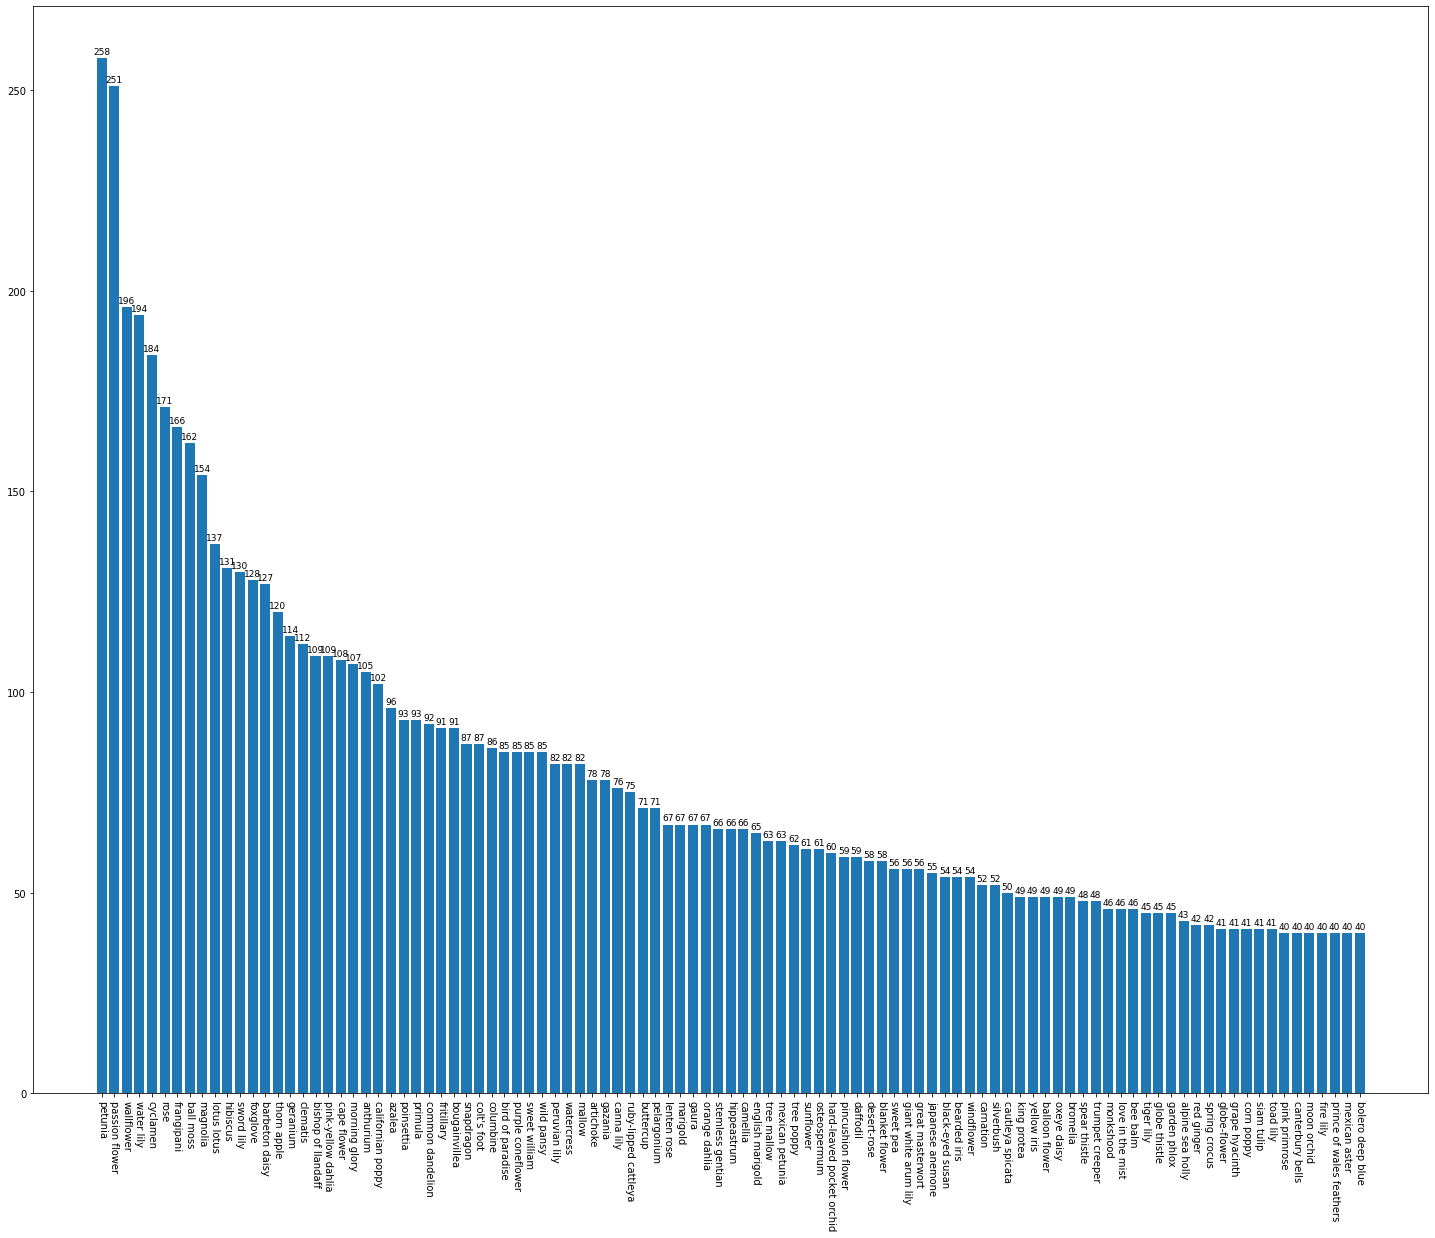

In [6]:
class_num,count_dict_sorted = class_imbalance('./imagelabels.mat')

In [8]:
img_dir = "./jpg"
imgs_path = list(Path(img_dir).glob('*.jpg'))
labels = scipy.io.loadmat("./imagelabels.mat")
labels = labels['labels'][0]
new_labels,new_imgs_path = data_augmentation(list(labels),list(imgs_path),img_dir)

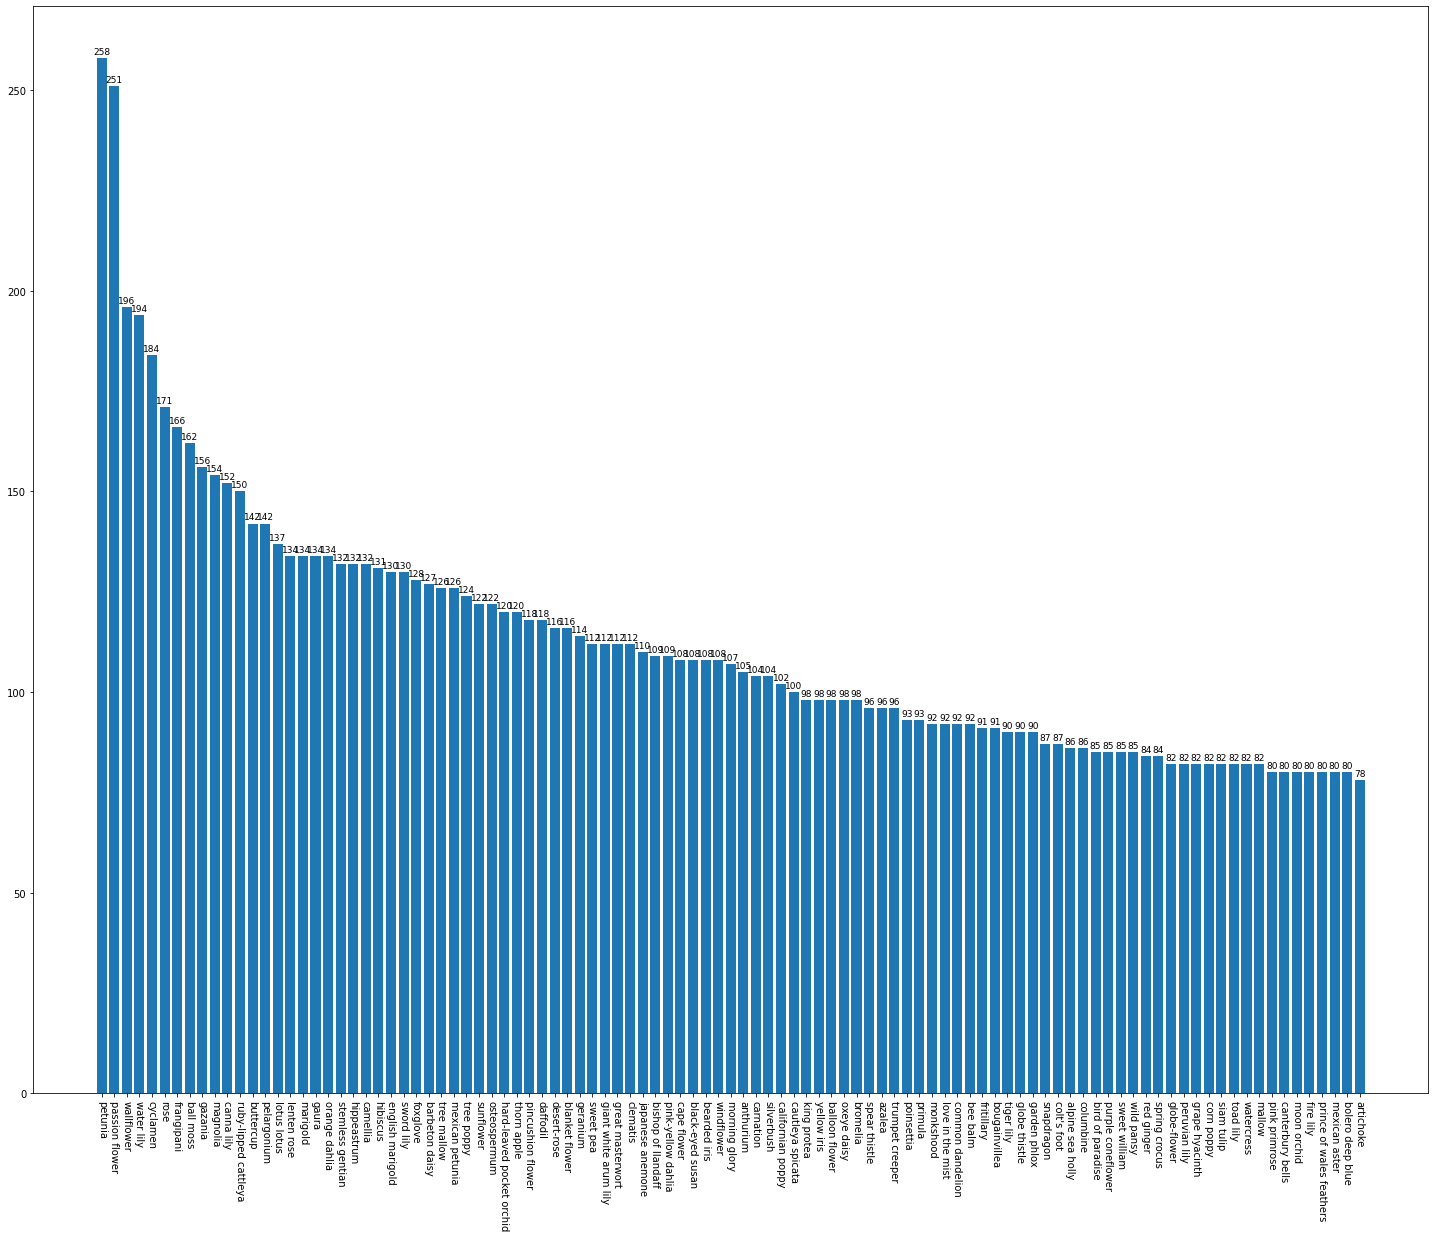

In [20]:
n_class_num,n_count_dict_sorted = class_imbalance('./new_imagelabels.mat')

In [24]:
from sklearn.model_selection import train_test_split
new_imgs_path = [str(path)[-15:] for path in new_imgs_path]
x_train, x_test, y_train, y_test = train_test_split(new_imgs_path, new_labels,test_size=0.2)
x_valid,x_test_2,y_valid,y_test_2 = train_test_split(x_test, y_test,test_size=0.5)

scipy.io.savemat('new_setid.mat',{'trnid':y_train,'valid':y_valid,'tstid':y_test_2,'trnpath':x_train,'valpath':x_valid,'tstpath':x_test})

In [25]:
print(scipy.io.loadmat('./new_setid.mat'))
print(scipy.io.loadmat('./new_imagelabels.mat'))

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Jan  2 21:40:48 2024', '__version__': '1.0', '__globals__': [], 'trnid': array([[22,  1, 58, ..., 21, 39, 78]], dtype=uint8), 'valid': array([[48,  3, 30, ..., 47, 81, 12]], dtype=uint8), 'tstid': array([[18, 32,  4, ..., 68, 29, 92]], dtype=uint8), 'trnpath': array(['image_09250.jpg', 'image_06745.jpg', 'image_02730.jpg', ...,
       'image_06783.jpg', 'image_10828.jpg', 'image_01835.jpg'],
      dtype='<U15'), 'valpath': array(['image_04635.jpg', 'image_06633.jpg', 'image_03495.jpg', ...,
       'image_08901.jpg', 'image_00889.jpg', 'image_04040.jpg'],
      dtype='<U15'), 'tstpath': array(['image_09578.jpg', 'image_00643.jpg', 'image_05421.jpg', ...,
       'image_02679.jpg', 'image_01465.jpg', 'image_05860.jpg'],
      dtype='<U15')}
{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Jan  2 20:59:41 2024', '__version__': '1.0', '__globals__': [], 'labels': array([[77, 77, 77, ..., 62, 62, 62]],

In [11]:
class FlowerDataset(torch.utils.data.Dataset):
    def __init__(self,img_dir, set_id_dir, transform, data_split):
        self.data_list = {'labels':[],'imgs_path':[]}
        self.img_dir = img_dir
        
        if data_split == 'train':
            self.data_list['labels'] = scipy.io.loadmat(set_id_dir)['trnid'][0]
            self.data_list['imgs_path'] = scipy.io.loadmat(set_id_dir)['trnpath']
        elif data_split == 'test':
            self.data_list['labels'] = scipy.io.loadmat(set_id_dir)['tstid'][0]
            self.data_list['imgs_path'] = scipy.io.loadmat(set_id_dir)['tstpath']
        elif data_split == 'valid':
            self.data_list['labels'] = scipy.io.loadmat(set_id_dir)['valid'][0]
            self.data_list['imgs_path'] = scipy.io.loadmat(set_id_dir)['valpath']
        
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.img_dir+'/'+ self.data_list['imgs_path'][index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = self.data_list['labels'][index]
        return img_transformed,label

    def __len__(self):
        return len(self.data_list['labels'])
    
# imgs_path = list(Path('./jpg').glob('*.jpg'))
# img=Image.open(imgs_path[0])
# print(img.size)


In [12]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=[-45.0, 45.0], expand=False, fill=0),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.025),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_data = FlowerDataset(img_dir='./jpg',
                           set_id_dir='./new_setid.mat',
                           transform=train_transforms,
                           data_split='train')

val_data = FlowerDataset(img_dir='./jpg',
                         set_id_dir='./new_setid.mat',
                         transform=val_transforms,
                         data_split='valid')

test_data = FlowerDataset(img_dir='./jpg',
                          set_id_dir='./new_setid.mat',
                          transform=test_transforms,
                          data_split='test')

batch_size = 24
train_dataloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True,num_workers=0)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True,num_workers=0)
val_dataloader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True,num_workers=0)

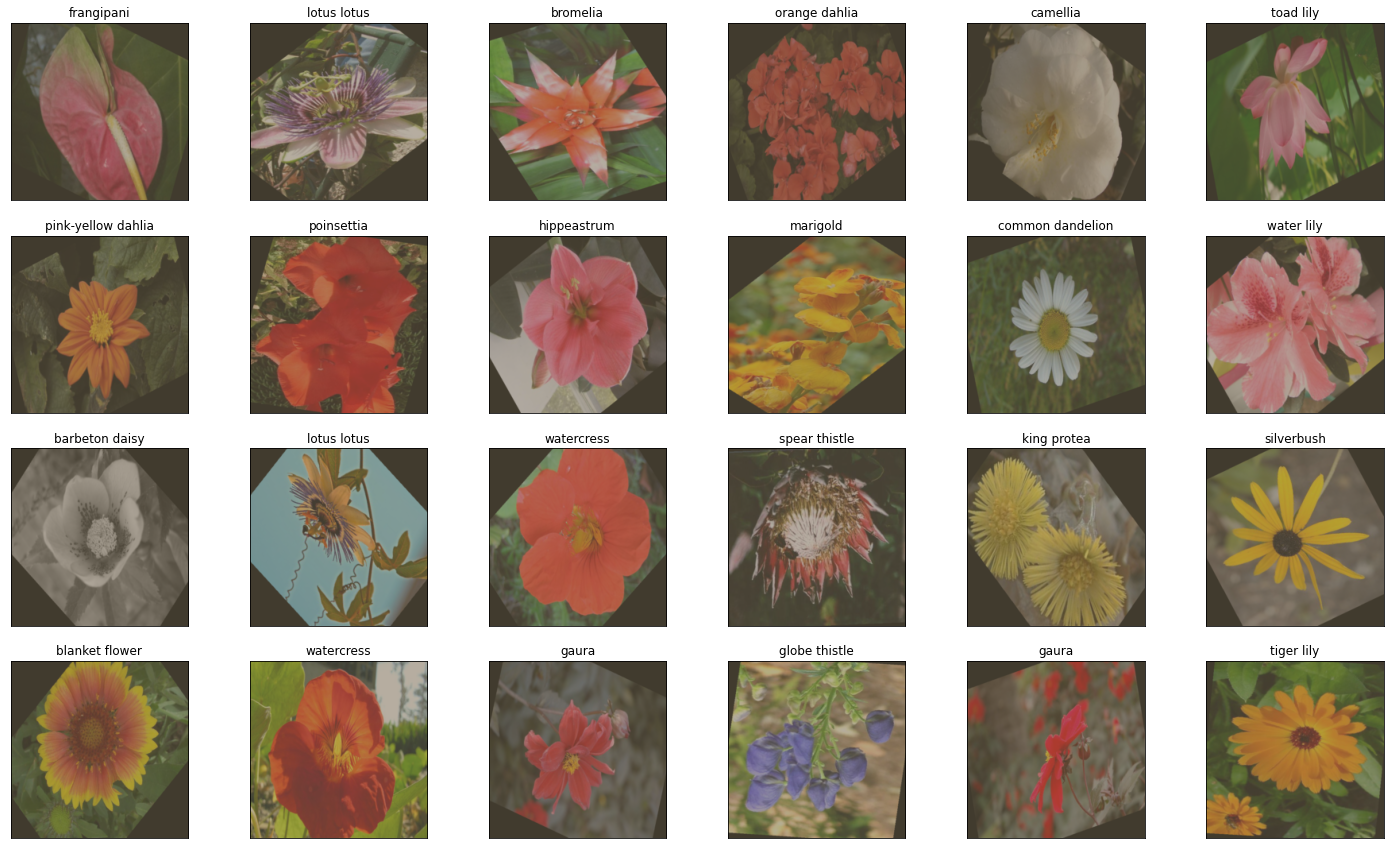

In [13]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    
    image = image.clip(0, 1)
    
    return image

fig = plt.figure(figsize = (25, 15))
columns = 6
rows = 4

dataiter = iter(train_dataloader)
inputs, classes = dataiter.next()

for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx + 1, xticks = [], yticks = [])
    ax.set_title(cat_to_name[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [14]:
def get_confusion_matrix(preds, labels, num_classes, normalize="true"):
    cmtx = confusion_matrix(
        labels, preds, labels=list(range(num_classes)))#, normalize=normalize) 
    return cmtx
def plot_confusion_matrix(cmtx, num_classes, class_names=None, figsize=None):
    if class_names is None or type(class_names) != list:
        class_names = [str(i) for i in range(num_classes)]

    figure = plt.figure(figsize=figsize)
    plt.imshow(cmtx, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black.
    threshold = cmtx.max() / 2.0
    for i in range(cmtx.shape[0]):
        for j in range(cmtx.shape[1]):
            color = "white" if cmtx[i, j] > threshold else "black"
            plt.text(
                j,
                i,
                format(cmtx[i, j], ".2f") ,
                horizontalalignment="center",
                color=color,
            )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    return figure

def add_confusion_matrix(
    writer,
    cmtx,
    num_classes,
    global_step=None,
    subset_ids=None,
    class_names=None,
    tag="Confusion Matrix",
    figsize=(35,35),
):
    if subset_ids is None or len(subset_ids) != 0:
        # If class names are not provided, use class indices as class names.
        if class_names is None:
            class_names = [str(i) for i in range(num_classes)]
        # If subset is not provided, take every classes.
        if subset_ids is None:
            subset_ids = list(range(num_classes))

        sub_cmtx = cmtx[subset_ids, :][:, subset_ids]
        sub_names = [class_names[j] for j in subset_ids]

        sub_cmtx = plot_confusion_matrix(
            sub_cmtx,
            num_classes=len(subset_ids),
            class_names=sub_names,
            figsize=figsize,
        )
        # Add the confusion matrix image to writer.
        writer.add_figure(tag=tag, figure=sub_cmtx, global_step=global_step)

In [29]:
def train(train_dataloader,val_dataloader,model,loss_function,optimizer,epochs,lr_scheduler):
    writer = SummaryWriter("tf-logs")
    min_acc = 0.0
    for epoch in range(epochs):
        running_loss = 0.0
        running_acc = 0.0
        running_correct = 0.0
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-"*20)
        model.train()
        for step, (images, labels) in enumerate(train_dataloader, start=0):
            img, label = images.to(device), labels.long().to(device)
            outputs = model(img)
            pred = outputs.argmax(dim=1)
            running_loss = loss_function(outputs, label)
            running_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            running_correct += torch.eq(pred, label).float().sum().item()
            running_acc = (running_correct / (len(train_dataloader) * batch_size))
            
            
            rate = (step + 1) / len(train_dataloader)
            print("\rtrain: {:^3.0f}% loss:{:.3f} train_acc:{:^3.5f}%".format(int(rate * 100), running_loss, 
                                                                                                (running_acc* 100)), end=" ")
            tag = "train_loss"
            writer.add_scalar(tag, global_step=step + len(train_dataloader) * epoch, scalar_value=running_loss)
        print(" ")
        if lr_scheduler is not None:
            lr_scheduler.step()

        
        
        # val
        running_correct = 0.0
        running_loss = 0.0
        running_acc = 0.0
        test_label = []
        test_pred = []
        model.eval()
        with torch.no_grad():
            for step, (images, labels) in enumerate(val_dataloader, start=0):
                img, label = images.to(device), labels.long().to(device)
                outputs = model(img)
                pred = outputs.argmax(dim=1)
                running_loss = loss_function(outputs, label)

                running_correct += torch.eq(pred, label).float().sum().item()
                running_acc = running_correct / (len(val_dataloader) * batch_size)

                rate = (step + 1) / len(val_dataloader)
                test_label.append(label.int().cpu())
                test_pred.append(pred.int().cpu())
                print("\rtest: {:^3.0f}% loss:{:.3f} test_acc:{:^3.5f}%".format(int(rate * 100), running_loss,
                                                                                (running_acc * 100)), end=" ") 
                
            if running_acc > min_acc:
                min_acc = running_acc
                print(f"save best model at {epoch+1}th epoch")
                torch.save(model, 'best_model.pth')
                
        tensor_pred = torch.cat(test_pred, dim=0)
        tensor_label = torch.cat(test_label, dim=0)
        cmtx = get_confusion_matrix(tensor_pred, num_classes=102, labels=tensor_label)
        tag = 'Confusion_Matrix'
        add_confusion_matrix(writer, cmtx,num_classes=102, tag= tag,
                              global_step=epoch)
        tag = "test_acc"
        writer.add_scalar(tag,global_step=epoch,scalar_value=running_acc)
        

def evaluate(model, loss_function,test_dataloader):
    running_correct = 0.0 
    running_loss = 0.0
    running_acc = 0.0
    class_label = [0 for i in range(102)]
    class_correct = [0 for i in range(102)]
    class_sen = [0.0 for i in range(102)]
    model.eval()
    corrects = eval_loss = 0
    with torch.no_grad():
        for step, (images, labels) in enumerate(val_dataloader, start=0):
            img, label = images.to(device), labels.long().to(device)
            output = model(img)
            loss = loss_function(output, label)
            pred = output.argmax(dim=1)
            running_loss = loss_function(output, label)

            running_correct += torch.eq(pred, label).float().sum().item()
            running_acc = running_correct / (len(val_dataloader) * batch_size)
            
            for i in range(len(label)):
                class_label[label[i]-1] += 1
                class_correct[label[i]-1] += (torch.eq(pred,label).int().tolist())[i]
                class_sen[label[i]-1] = class_correct[label[i]-1]/class_label[label[i]-1]

            rate = (step + 1) / len(val_dataloader)
            print("\rtest: {:^3.0f}% loss:{:.3f} test_acc:{:^3.5f}%".format(int(rate * 100), running_loss,
                                                                                (running_acc * 100)), end=" ") 
            
        return class_sen
            
                

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet50(pretrained=True)
model.to(device)
loss_function = nn.CrossEntropyLoss()
#loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
epochs = 30
#print(model)

In [26]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
train(train_dataloader,val_dataloader,model,loss_function,optimizer,epochs,scheduler)


Epoch 1/30
--------------------
train: 100% loss:4.385 train_acc:42.85714%  
test: 100% loss:1.222 test_acc:65.53819% save best model at 1th epoch

Epoch 2/30
--------------------
train: 100% loss:1.164 train_acc:74.68615%  
test: 100% loss:0.651 test_acc:80.72917% save best model at 2th epoch

Epoch 3/30
--------------------
train: 100% loss:3.715 train_acc:83.31169%  
test: 100% loss:0.371 test_acc:84.72222% save best model at 3th epoch

Epoch 4/30
--------------------
train: 100% loss:1.262 train_acc:87.84632%  
test: 100% loss:0.229 test_acc:91.57986% save best model at 4th epoch

Epoch 5/30
--------------------
train: 100% loss:2.523 train_acc:89.77273%  
test: 100% loss:0.102 test_acc:92.27431% save best model at 5th epoch

Epoch 6/30
--------------------
train: 100% loss:0.259 train_acc:95.75758%  
test: 100% loss:0.005 test_acc:97.65625% save best model at 6th epoch

Epoch 7/30
--------------------
train: 100% loss:3.626 train_acc:97.72727%  
test: 100% loss:0.004 test_acc:98.

In [30]:
model_test = torch.load("best_model.pth")


In [32]:
test_result=evaluate(model_test,loss_function,test_dataloader)
def print_result(class_sen):         
    print("-"*100)
    print("|"f"|{'id':^10}|{'class':^40}|{'Acc':^20}|{'#pic':^20}|")
    print("-"*100)
    for i in range(102):
        if class_sen[i] < 1.0:   
            print("|"f"|{i:^10}|{cat_to_name[i]:^40}|{class_sen[i]:^20}|{n_class_num[i]:^20}|")
        
print_result(test_result)

test: 100% loss:0.014 test_acc:99.47917% ----------------------------------------------------------------------------------------------------
||    id    |                 class                  |        Acc         |        #pic        |
----------------------------------------------------------------------------------------------------
||    3     |               sweet pea                | 0.9285714285714286 |        112         |
||    15    |              globe-flower              | 0.8333333333333334 |         82         |
||    17    |             peruvian lily              |        0.9         |         82         |
||    49    |            common dandelion            |        0.9         |         92         |
||    87    |                magnolia                | 0.9285714285714286 |        154         |
||    92    |                bee balm                |       0.875        |         92         |
